In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import json
import pickle
import os
import numpy as np
import proplot as pplt
import warnings
warnings.filterwarnings("ignore")

COLORS = []

colors = pplt.Cycle('ggplot')
for color in colors:
    COLORS.append(color['color'])
colors = pplt.Cycle('default')
for color in colors:
    COLORS.append(color['color'])

COLORS[0], COLORS[1] = COLORS[1], COLORS[0]

    
pplt.rc['figure.facecolor'] = 'white'

RESULT_DIR = "../../mpcd_result/"
DATA_DIR    = "../../mpcd/result_1106/"
FIGURE_DIR = "../../mpcd_figure/"

with open('plot_style.json', 'r') as f:
    format_params = json.load(f)
    
MOMENTS    = np.array([0.1, 0.08, 0.06, 0.04, 0.030, 0.024, 0.018, 0.012, 
                    0.006, 0.003, 0.001, 0.0008, 0.0006, 0.0004])

def format_ax(ax):
    ax.format(**format_params)
    ax.tick_params(top=True, right=True, bottom=True, left=True, which='both')
    ax.minorticks_on()

In [ ]:
from cg_topo_solv.analysis.result import get_meta_counts
from cg_topo_solv.ml.latent_sampling import latent_sampling

### Load Target Curves and Seed Data

In [5]:
META_KEYS_PATH = os.path.join(RESULT_DIR, "meta_keys.pickle")

with open(os.path.join(RESULT_DIR, "target_curves.pickle"), "rb") as f:
    target_curves = pickle.load(f)["curves"]

if os.path.exists(META_KEYS_PATH):
    with open(META_KEYS_PATH, "rb") as f:
        meta_keys = pickle.load(f)
else:
    meta_count = get_meta_counts(data_dir=DATA_DIR)
    meta_keys_all = list(meta_count.keys())
    meta_numbers = np.array([int(k.split("_")[1]) for k in meta_keys_all])

    sample, z_mean, y_all, c_all, graph_all = latent_sampling(
        seed=42, mode="maximin_sampling", rerun=False, size=30
    )

    idx_map = [np.where(meta_numbers == i)[0][0] for i in range(30)]
    meta_keys = [meta_keys_all[idx] for idx in idx_map]

    with open(META_KEYS_PATH, "wb") as f:
        pickle.dump(meta_keys, f)

with open(os.path.join(RESULT_DIR, "raw_visc_seed.pickle"), "rb") as f:
    outputs = np.array(pickle.load(f))

with open(os.path.join(RESULT_DIR, "fit_visc_seed.pickle"), "rb") as f:
    new_xx = np.array(pickle.load(f))
    new_yy_real = np.array(pickle.load(f))
    topo_real = np.array(pickle.load(f))
    ps_real = np.array(pickle.load(f))

Loaded sampled latent space points from sample_z_mean_maximin_sampling.pickle


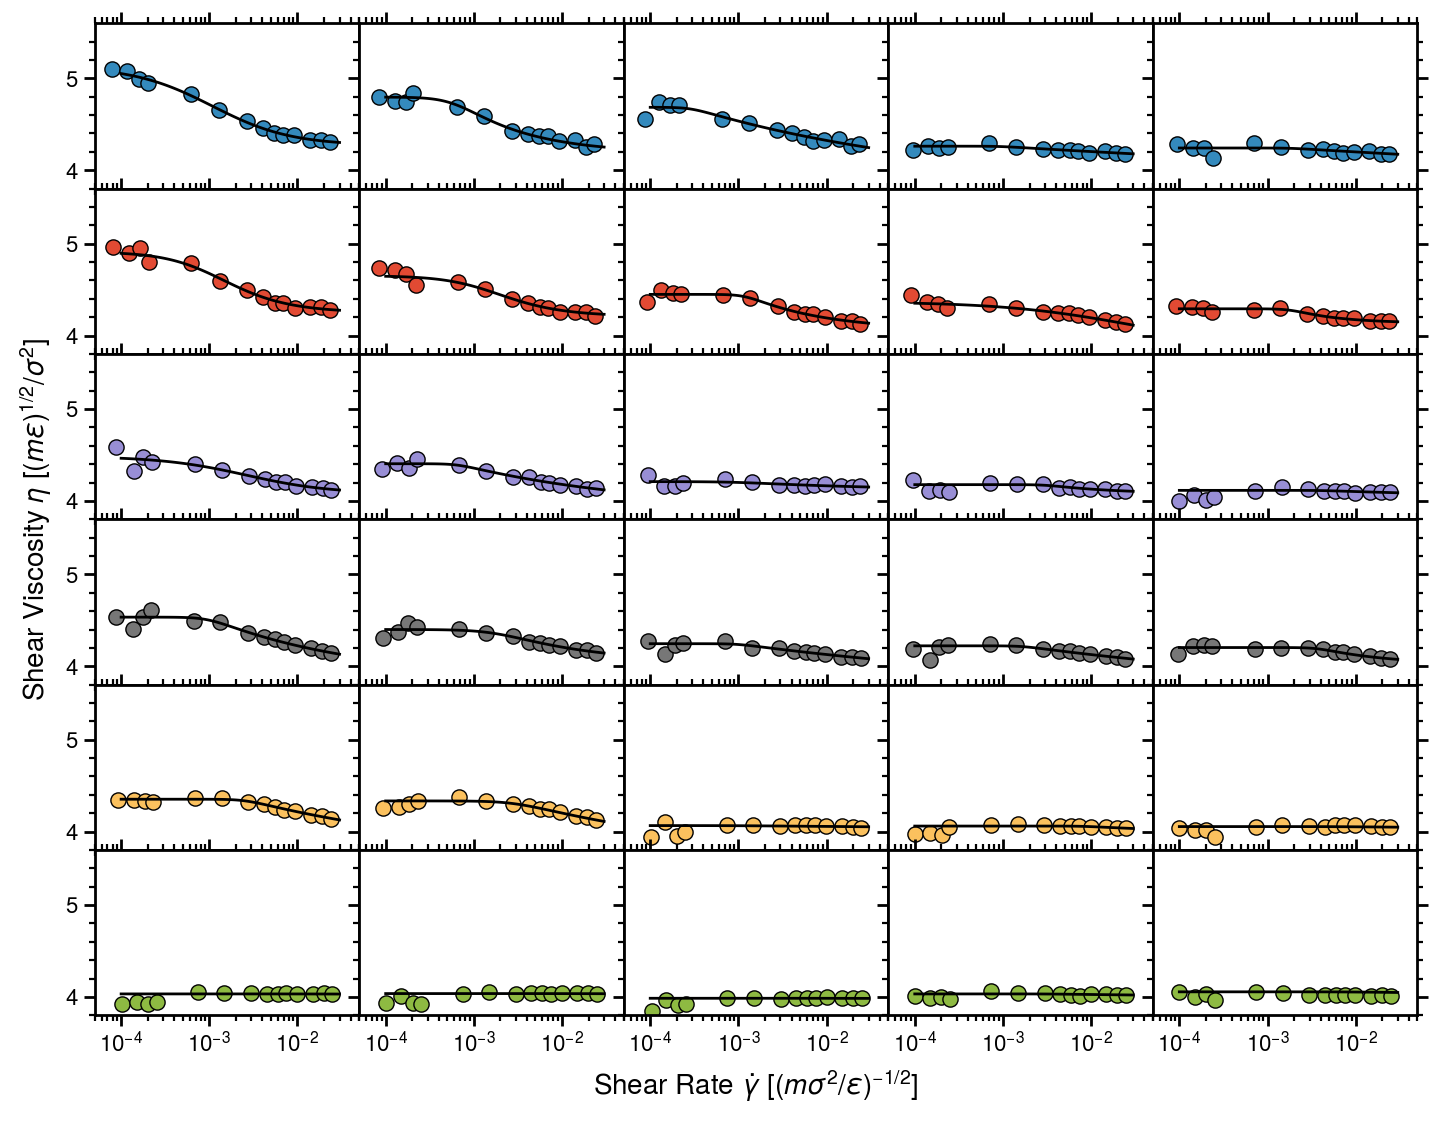

In [7]:
ordered_indices = []

fig, ax = pplt.subplots(ncols=5, nrows=6, refaspect=1.6, share=True, wspace=0, hspace=0, journal="nat2")

format_params_update = {
    'xscale': 'log',
    'xlim': [5e-5, 5e-2],
    'ylim': [3.8, 5.6],
    'xticks': [1e-4, 1e-3, 1e-2],
    'xticklabels': [r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$'],
    'xlabel': r'Shear Rate $\dot{\mathit{\gamma}}~[(\mathit{m}\mathit{\sigma}^2/\mathit{\epsilon})^{-1/2}]$',
    'ylabel': r'Shear Viscosity $\mathit{\eta}~[(\mathit{m}\mathit{\epsilon})^{1/2}/\mathit{\sigma}^2]$',
}

color = {
    "branch": COLORS[2],
    "comb": COLORS[1],
    "star": COLORS[4],
    "linear": COLORS[0],
    "dendrimer": COLORS[5],
    "cyclic": COLORS[3],
}

grouped_data = {}

for i, meta_key in enumerate(meta_keys):
    key = meta_key.split("_")[0]
    if key not in grouped_data:
        grouped_data[key] = []
    grouped_data[key].append(i)

grouped_data = {
    'linear': [20, 21, 22, 23, 24],
    'comb': [5, 6, 7, 8, 9],
    'branch': [0, 1, 2, 3, 4],
    'cyclic': [10, 11, 12, 13, 14],
    'star': [25, 26, 27, 28, 29],
    'dendrimer': [15, 16, 17, 18, 19]
}

for row, (key, indices) in enumerate(grouped_data.items()):

    if row != 5:
        sorted_indices = sorted(
            indices,
            key=lambda idx: -new_yy_real[idx][0])
    else:
        sorted_indices = [19, 17, 15, 16, 18]

    for col, idx in enumerate(sorted_indices):
        plot_idx = row * 5 + col
        ordered_indices.append(idx)
        
        ax[plot_idx].errorbar(
            outputs[idx]['shear_rate'][:, 0], 
            outputs[idx]['mean_viscosity'],
            yerr=outputs[idx]['std_viscosity'] * 1.96,
            xerr=outputs[idx]['shear_rate'][:, 1] * 1.96,
            fmt='none',
            ecolor=color[key],
            capsize=2,
            elinewidth=1,
            zorder=1
        )

        ax[plot_idx].scatter(
            outputs[idx]['shear_rate'][:, 0], 
            outputs[idx]['mean_viscosity'],
            facecolor=color[key],
            edgecolor='black',
            s=30,
            linewidth=0.5,
            label="Data",
            zorder=2
        )

        ax[plot_idx].plot(new_xx[idx], new_yy_real[idx], 'k', zorder=3, label="Fit", lw=1)
        
        ax[plot_idx].tick_params(top=True, right=True, which='both')
        ax[plot_idx].tick_params(bottom=True, left=True, which='both')
        ax[plot_idx].minorticks_on()
        ax[plot_idx].grid()
        format_ax(ax[plot_idx])
        ax[plot_idx].format(**format_params_update)

In [7]:
import umap
import alphashape

from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry import Polygon
from descartes import PolygonPatch
from scipy.interpolate import splprep, splev
from scipy.stats import zscore
from numpy.linalg import norm

In [8]:
TARGET_CURVES_PATH = os.path.join(RESULT_DIR, "target_curves.pickle")
META_KEYS_PATH = os.path.join(RESULT_DIR, "meta_keys.pickle")
RAW_VISC_PATH = os.path.join(RESULT_DIR, "raw_visc_seed.pickle")
FIT_VISC_PATH = os.path.join(RESULT_DIR, "fit_visc_seed.pickle")

with open(TARGET_CURVES_PATH, "rb") as f:
    target_curves = pickle.load(f)["curves"]

if os.path.exists(META_KEYS_PATH):
    with open(META_KEYS_PATH, "rb") as f:
        meta_keys = pickle.load(f)
else:
    meta_count = get_meta_counts(data_dir=DATA_DIR)
    meta_keys_all = list(meta_count.keys())
    meta_numbers = np.array([int(k.split("_")[1]) for k in meta_keys_all])

    sample, z_mean, y_all, c_all, graph_all = latent_sampling(
        seed=42, mode="maximin_sampling", rerun=False, size=30
    )

    idx_map = [np.where(meta_numbers == i)[0][0] for i in range(30)]
    meta_keys = [meta_keys_all[idx] for idx in idx_map]

    with open(META_KEYS_PATH, "wb") as f:
        pickle.dump(meta_keys, f)

with open(RAW_VISC_PATH, "rb") as f:
    outputs = np.array(pickle.load(f))

with open(FIT_VISC_PATH, "rb") as f:
    new_xx = np.array(pickle.load(f))
    new_yy_real = np.array(pickle.load(f))
    topo_real = np.array(pickle.load(f))
    ps_real = np.array(pickle.load(f))

In [9]:
UMAP_DIM = 3
N_NEIGHBORS = 200
MIN_DIST = 0.6
UMAP_PATH = f"/home/sj0161/mpcd_result/umap_{UMAP_DIM}d_{N_NEIGHBORS}_{MIN_DIST}.pickle"

if os.path.exists(UMAP_PATH):
    with open(UMAP_PATH, "rb") as f:
        mus_2d = pickle.load(f)
        mus_2d_subset = pickle.load(f)
        umap_reducer = pickle.load(f)
else:
    umap_reducer = umap.UMAP(
        n_components=UMAP_DIM,
        random_state=42,
        n_neighbors=N_NEIGHBORS,
        min_dist=MIN_DIST
    )
    umap_reducer.fit(z_mean)
    mus_2d = umap_reducer.transform(z_mean)
    mus_2d_subset = umap_reducer.transform(z_mean[sample])

    with open(UMAP_PATH, "wb") as f:
        pickle.dump(mus_2d, f)
        pickle.dump(mus_2d_subset, f)
        pickle.dump(umap_reducer, f)

mus_mean = mus_2d.mean(axis=0)
mus_2d_subset -= mus_mean
mus_2d -= mus_mean

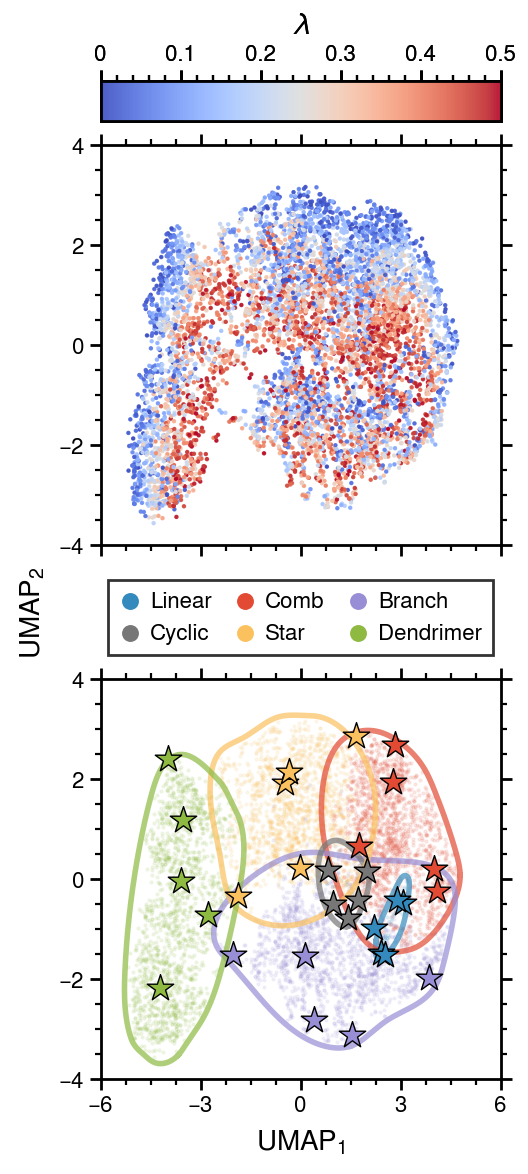

In [10]:
class_labels = ["linear", "comb", "branch", "cyclic", "star", "dendrimer"]

labels = [r"$\mathit{\lambda}$", class_labels]
tick_ranges = [[0, 0.1, 0.2, 0.3, 0.4, 0.5]]
ticks = [0.1]

fig, ax = pplt.subplots(refwidth=2, refheight=2, nrows=2, share=True)

for i, j in enumerate([-1, 2]):
    color_values = y_all[:, j]

    if i == 0:
        scatter_handle = ax[i].scatter(
            mus_2d[:, 0],
            mus_2d[:, 2],
            c=color_values,
            cmap="coolwarm",
            s=1,
            vmin=tick_ranges[i][0],
            vmax=tick_ranges[i][-1], 
            alpha=0.9
        )

    else:

        for index, label in enumerate(class_labels):
            color = COLORS[index % len(COLORS)]
            mask = c_all == label
            x_temp = mus_2d[mask, 0]
            y_temp = mus_2d[mask, 2]
            ax[i].scatter(x_temp, y_temp, color=color, s=1, alpha=0.1)
        
            coords = np.stack((x_temp, y_temp), axis=1)
            zscores = np.abs(zscore(coords, axis=0))
            if label == "branch":
                filtered = coords[(zscores < 2.5).all(axis=1)]
            else:
                filtered = coords[(zscores < np.inf).all(axis=1)]
        
            alpha_shape = alphashape.alphashape(filtered, .001)
            if alpha_shape.geom_type == 'Polygon':
                boundary = np.array(alpha_shape.exterior.coords)
                x, y = boundary[:, 0], boundary[:, 1]
                tck, u = splprep([x, y], s=.001, per=True)
                smooth = splev(np.linspace(0, 1, 1000), tck)
                smooth_boundary = np.vstack(smooth).T
        
                v = np.roll(smooth_boundary, -1, axis=0) - np.roll(smooth_boundary, 1, axis=0)
                normals = np.column_stack([-v[:, 1], v[:, 0]])
                normals /= np.linalg.norm(normals, axis=1)[:, None]
        
                extended_boundary = smooth_boundary + 0.1 * normals
                ax[i].plot(extended_boundary[:, 0], extended_boundary[:, 1], color=color, linewidth=2, alpha=0.7)
                
    for k, j in enumerate([4, 1, 0, 2, 5, 3]):
        if i == 1:
            ax[i].scatter(
                mus_2d_subset[j*5:(j+1)*5, 0],
                mus_2d_subset[j*5:(j+1)*5, 2],
                facecolor=COLORS[k],
                edgecolor="k",
                marker="*",
                linewidth=0.5,
                s=100,
                alpha=1.0,
                zorder=4,
            )   
    
    if i == 0:
        colorbar = ax[i].colorbar(
            scatter_handle,
            label=labels[i],
            ticks=ticks[i],
            labelsize=10,
            linewidth=1.0,
            loc="t",
        )
    
        colorbar.ax.minorticks_on()
        colorbar.ax.tick_params(which="both", top=True, labelsize=8)
    else:
        legend_handles = []
        for index, label in enumerate(labels[i]):
            color = COLORS[index % len(COLORS)]
            handle = ax[i].scatter([], [], color=color, s=30, label=label.capitalize())
            legend_handles.append(handle)
        
        legend = ax[i].legend(handles=legend_handles, loc='t', ncols=3, prop={'size': 8},
            handletextpad=0.4,
            columnspacing=1,
            handlelength=1
        )
        legend.get_frame().set_linewidth(1)

    format_ax(ax[i])
    ax[i].format(
        xticks=[-6, -3, 0, 3, 6],
        yticks=[-4, -2, 0, 2, 4],
        xlim=[-6, 6],
        ylim=[-4, 4],
        xlabel=r"$\mathrm{UMAP}_1$",
        ylabel=r"$\mathrm{UMAP}_2$",
    )